## Converting image to frequency domain

**Aim:** Approximating given image of a shape- tested on circle and square

**Strategy:**
- Edge detection 
- Apply Fourier Transform to convert to frequency domain
- Plot reconstructed image

### Initializing

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

original_center = 0.0
original_radius = 0.0
approx_center   = 0.0
approx_radius   = 0.0

scale_factor    = 0.0
shift           = 0.0

In [2]:
#Load and convert image to grayscale
img = cv2.imread('tiger.png')
assert img is not None, "Image path not loaded correctly"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #CV uses BGR instead of RGB

# convert the image to grayscale format
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

#blur the image using Gaussian filter for noise reduction
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0)

### Edge detection

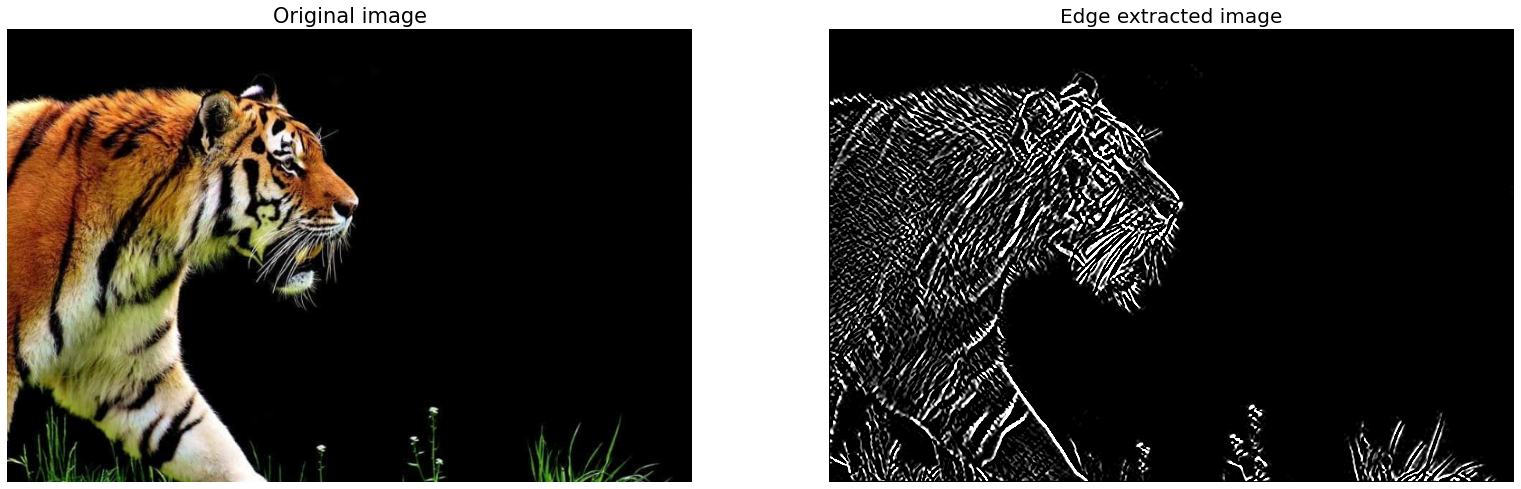

In [3]:
# Sobel Edge Detection
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5)
 
fig, axs = plt.subplots(1, 2, figsize=(27, 9))
axs[0].imshow(img)
axs[0].set_title("Original image", fontsize = 21)
axs[0].axis('off')
axs[1].imshow(sobelxy, cmap='gray', vmin=0, vmax=255)
axs[1].set_title("Edge extracted image", fontsize = 20)
axs[1].axis('off') 
plt.show()

### Fourier Transform on coordiantes

In [5]:
ft_sobelxy = np.fft.fft2(sobelxy)
ft_sobelxy_shifted = np.fft.fftshift(ft_sobelxy)  # Center the zero frequency component
magnitude_sobelxy = np.abs(ft_sobelxy_shifted)

# Extract frequencies (The frequencies correspond to the indices in the FT output)
frequencies_x = np.fft.fftfreq(ft_sobelxy_shifted.shape[0])
frequencies_y = np.fft.fftfreq(ft_sobelxy_shifted.shape[1])